# Direct Preference Optimization (DPO) for LLM Alignment

## Introduction

This project demonstrates how to align language models with human preferences using Direct Preference Optimization (DPO). DPO is a modern alternative to traditional RLHF that bypasses the need for reinforcement learning and reward models, making it simpler and more stable to implement.

We'll apply DPO to the SmolLM-135M model, showing how to:
- Train a policy model to prefer human-chosen responses
- Use preference pairs instead of scalar rewards
- Achieve alignment without complex RL algorithms

This builds upon the transformer implementation and showcases cutting-edge alignment techniques used in production LLMs.

## Setup

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
import nltk
# For tokenization and dataset loading
from transformers import AutoTokenizer
from datasets import load_dataset
import string
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import random

In [127]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [101]:
torch.manual_seed(42)

### Initializing device here for future use if needed

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### SmolLM Model Architecture

The following cells contain the complete SmolLM implementation, including:
- Grouped-Query Attention with RoPE
- LlamaDecoder blocks with RMSNorm
- Gated MLP layers
- Full language model with tied embeddings

This is the same architecture used in the Transformer-LLM-Implementation project.

In [103]:
from dataclasses import dataclass

@dataclass 
class smolConfig:
    vocab_size = 49152
    hidden_size = 576
    intermediate_size = 1536
    num_hidden_layers = 30
    num_heads = 9
    kv_heads = 3

In [104]:
def rotate_half(x):
    """
    Helper function to rotate the left half of a tensor along its final dimension.
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]

    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """
    Applies RoPE on the query and key tensors.
    """
    cos, sin = cos.to(q.device), sin.to(q.device)

    # Unsqueexzing to enable broadcasting
    sin = sin.unsqueeze(unsqueeze_dim)
    cos = cos.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        # Precompute frequency for sine/cosine embeddings
        self.freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))

    @torch.no_grad()
    def forward(self, x):
        # Generate positions (sequence indices) for the input
        pos = torch.arange(x.shape[-2], dtype=torch.long)
        # Compute angles for sine and cosine embeddings
        angles = torch.einsum("p,f->pf", pos.float(), self.freq).unsqueeze(dim=0)
        # Duplicate angles for sine and cosine embeddings
        emb = torch.cat((angles, angles), dim=-1)
        # Return cosine and sine components of the positional embeddings
        return emb.cos(), emb.sin()

class GroupedQueryAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Model dimensions and attention configurations
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.kv_heads = config.kv_heads  # Number of key-value heads
        self.rope_theta = 10000.0  # Scaling factor for rotary embeddings

        # Linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)

        # Rotary embedding generator
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta, dim=self.head_dim)

    def _repeat_kv(self, x, n_rep):
        batch, num_key_value_heads, slen, head_dim = x.shape
        # Expand the number of key-value heads by repeating them
        x = x[:, :, None, :, :].expand(
            batch, num_key_value_heads, n_rep, slen, head_dim
        )
        # Reshape to align with the expected multi-head attention format
        return x.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)
    
    def forward(self, x: torch.Tensor, attention_mask=None):
        # Input dimensions: (batch_size, seq_len, hidden_size)
        b, q, _ = x.size()

        # Project input hidden states into queries, keys, and values
        q_states = self.q_proj(x)
        k_states = self.k_proj(x)
        v_states = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        # Compute rotary positional embeddings
        cos, sin = self.rotary_emb(q_states)
        cos = cos.to(q_states.device)
        sin = sin.to(q_states.device)
        # Apply positional embeddings to queries and keys
        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        # Repeat key and value tensors to match the number of query heads
        __kv_groups = self.num_heads // self.kv_heads
        k_states = self._repeat_kv(k_states, __kv_groups)
        v_states = self._repeat_kv(v_states, __kv_groups)

        # Compute attention scores (scaled dot-product attention)
        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        # Add attention mask (e.g., for causal or padding masking)
        attn_weights = attn_weights + attention_mask

        # Normalize attention weights using softmax
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        # Apply dropout to attention weights
        attn_weights = nn.functional.dropout(attn_weights, 0)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, v_states)
        # Reshape and transpose back to original format
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        # Project the attention output back to the hidden size
        attn_output = self.o_proj(attn_output)

        # Return the final attention output
        return attn_output

In [105]:
torch.manual_seed(42)

class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        This is the Root Mean Square Normalisation class.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))  # Learnable scaling factor
        self.variance_epsilon = eps

    def forward(self, x):
        # Calculate variance along the last dimension (hidden size)
        variance = x.pow(2).mean(-1, keepdim=True)

        # Normalize and scale
        x = x * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * x

class MLP(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        """
        This is the gated MLP from the LLaMa architecture. Here we use the SiLU acitvation.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.activation = nn.modules.activation.SiLU()

        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

    def forward(self, x):
        down_proj = self.down_proj(self.activation(self.gate_proj(x)) * self.up_proj(x))
        return down_proj
    
class LlamaDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        """
        This is the Llama decoder block.
        """
        # Self Attention Module
        self.self_attn = GroupedQueryAttention(config)

        # FFN Module
        self.mlp = MLP(hidden_size=config.hidden_size, intermediate_size=config.intermediate_size)

        # Pre Attention and Post Attention normalisation
        self.input_layernorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, x, attention_mask):
        # Skip connection cache
        
        residual = x

        # Pre-attention normalisation
        x = self.input_layernorm(x)

        # A causal attention mask (i.e., decoder can only look at tokens that it has generated thus far)
        attention_mask = torch.triu(torch.full((attention_mask.shape[-1], attention_mask.shape[-1]),
                                               fill_value=float('-inf')), diagonal=1)
        
        attention_mask = attention_mask.to(x.device)

        # Self-attention block
        x = self.self_attn(x=x,attention_mask=attention_mask)
        x += residual

        # Skip connection cache for MLP
        residual = x

        # Pre-MLP normalisation
        x = self.post_attention_layernorm(x)

        # MLP block
        x = self.mlp(x)
        x += residual

        return x

In [106]:
torch.manual_seed(42)

class smolModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # embedding layer which maps each token to a vector embedding
        self.embed_tokens = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.hidden_size
        )

        # Stack of decoder layers (LlamaDecoder) defined by the configuration
        self.layers = nn.ModuleList([
            LlamaDecoder(config) for _ in range(config.num_hidden_layers)
        ])

        # RMSNorm: final layer normalization applied to hidden states
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, input_ids=None, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        x = inputs_embeds

        # Pass embeddings through each decoder layer
        for i, decoder_layer in enumerate(self.layers):
            layer_outputs = decoder_layer(
                x,
                attention_mask=attention_mask
            )
            x = layer_outputs

        # Final normalisation
        x = self.norm(x)
    
        return x
    
class smolLM(nn.Module):
    """
    This is the Language Model. 
    It passes the embeddings from the SmolLM backbone into a LM head.
    The LM head generates logits over the space of the entire vocabulary for next word prediction.
    """
    def __init__(self, config):
        super().__init__()
        # SmolLM backbone which generates the contextualised embeddings for the input tokens
        self.model = smolModel(config)
        # The LM head which maps embeddings to logits over the vocabulary
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        # weights between LM head and the token_embedding layer are shared in the SmolLM architecture
        self.tie_weights()

    def tie_weights(self):
        # lm_head shares weights with the embedding layer
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, attention_mask):
        # Input tokens are passed to the SmolLM backbone
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # embeddings corresponding to each input token => (batch_size, seq_len, emb_dim)
        x = outputs

        # pass the embeddings through the LM head
        logits = self.lm_head(x).float()
        return {'logits': logits}

In [107]:
def __generate(model, inputs, num_tokens, tokenizer, max_length=50):
    """
    A basic greedy approach for text generation.
    """
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0, -1]).item()
        collect.append(output_id)
        if output_id == tokenizer.eos_token_id or len(collect) >= max_length:
            break
        # Update input_ids and attention_mask
        new_token = torch.tensor([output_id], device=inputs['input_ids'].device)
        inputs['input_ids'] = torch.cat([inputs['input_ids'][0], new_token]).unsqueeze(0)
        inputs['attention_mask'] = F.pad(inputs['attention_mask'], (0, 1), value=1)
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

## Preference Optimization: PPO vs DPO

In the typical LLM training pipeline, after pre-training, models undergo supervised fine-tuning (SFT) followed by alignment with human preferences.

### Traditional Approach: PPO (Proximal Policy Optimization)
The traditional method uses **Reinforcement Learning from Human Feedback (RLHF)**:
1. Train a reward model on human preference data
2. Use PPO to optimize the policy against the reward model
3. Complex training with actor-critic architecture

### Modern Approach: DPO (Direct Preference Optimization)
DPO simplifies this dramatically:
1. **No reward model needed** - learns directly from preferences
2. **Supervised learning** - uses standard gradient descent
3. **More stable** - avoids RL instability issues
4. **Simpler implementation** - contrastive loss on preference pairs

The key insight: Instead of learning a reward function and then optimizing against it, DPO directly optimizes the policy to prefer chosen responses over rejected ones.

### Real-World Usage
- DeepSeek-V3 uses GRPO (Group Relative Policy Optimization), a PPO variant
- Many modern LLMs are moving toward DPO-style methods for efficiency
- DPO has become the go-to for fine-tuning open-source models

### DPO

**Direct Preference Optimization (DPO)** is a technique used to align language models with human preferences without needing reinforcement learning or a separate reward model.

Instead of training a reward model, DPO directly learns from data where humans have ranked one response as better than another for the same prompt. This is done using a contrastive loss: the model is trained to assign higher likelihood to the preferred (chosen) response than the rejected one.

### How It Works

Given a dataset of triplets:
- `prompt`
- `chosen response` (preferred by humans)
- `rejected response` (less preferred)

The model compares its confidence (log-likelihood) in both responses, and adjusts itself to prefer the better one.

### Model Setup: Policy and Reference Models

For DPO training, we need two models:

1. **Policy Model** (trainable): The model we're aligning with human preferences
2. **Reference Model** (frozen): The baseline SFT model that anchors our optimization

Both start from the same fine-tuned weights, but only the policy model's parameters will be updated. The reference model provides a stable comparison point to prevent the policy from drifting too far from reasonable outputs.

In [158]:
# Load model config
config = smolConfig()

# TODO: Initiliaze the policy model and load the weights
policy_model = smolLM(config)
policy_model.load_state_dict(torch.load("/kaggle/input/pa4/pytorch/default/1/full_finetuned_smolLM.pth", weights_only=True))

# TODO: Initialize the reference model and load the weights
reference_model = smolLM(config)
reference_model.load_state_dict(torch.load("/kaggle/input/pa4/pytorch/default/1/full_finetuned_smolLM.pth", weights_only=True))

reference_model.eval()

# TODO: Freeze all parameters in the reference model
for param in reference_model.parameters():
    param.requires_grad = False

# Move the models to the appropriate device (GPU or CPU)
policy_model.to(device)
reference_model.to(device)

smolLM(
  (model): smolModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoder(
        (self_attn): GroupedQueryAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): RotaryEmbedder()
        )
        (mlp): MLP(
          (activation): SiLU()
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bias=

### Efficient Training: Partial Model Freezing

To make training feasible on consumer hardware, we freeze most of the policy model and only train the final layers. This approach:

- **Preserves pre-trained knowledge** in early layers
- **Reduces memory usage** significantly
- **Speeds up training** by limiting gradient computation
- **Focuses alignment** on high-level reasoning (later layers)

You can adjust `layers_to_freeze` based on your hardware constraints. Freezing the first 25 layers (out of 30) typically provides a good balance.

In [159]:
layers_to_freeze = 25

for name, param in policy_model.named_parameters():
    if name.startswith("model.embed_tokens"):
        param.requires_grad = False
    elif name.startswith("model.norm"):
        param.requires_grad = False
    elif name.startswith("lm_head"):
        param.requires_grad = True
    elif name.startswith("model.layers."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    else:
        param.requires_grad = True

Checking number of trainable parameters.

In [160]:
trainable_params = sum(p.numel()
                       for p in policy_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in policy_model.parameters())
print(
    f"Trainable params: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

Trainable params: 17,700,480 / 134,515,008 (13.16%)


### Parameter Efficiency

Even with ~25% trainable parameters, we can achieve effective alignment. The dataset size will be adjusted to balance training time and model performance.

### Dataset: Anthropic's HH-RLHF

We use the `Dahoas/full-hh-rlhf` dataset, which contains:
- **Prompts**: Questions or instructions
- **Chosen responses**: Human-preferred answers
- **Rejected responses**: Less preferred alternatives

This data comes from Anthropic's research on helpful and harmless AI assistants.

In [161]:
# Load dataset
dpo_dataset = load_dataset("Dahoas/full-hh-rlhf")

# Use only a small subset for fast training
data = dpo_dataset["train"].shuffle(seed=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")

# The tokenizer does not have a defined padding token, so we initialize our own as the EoS token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

### Data Quality Filtering

Not all preference pairs are equally informative. We filter for "strong preferences" by checking:

1. **Minimum length**: Both responses should be substantial (>60 chars)
2. **Clear difference**: Significant length difference between chosen/rejected
3. **Low overlap**: Not too similar in vocabulary
4. **Quality indicators**: 
   - Appropriate stop word ratios
   - More nouns/verbs in chosen response
   - No weak phrases like "I don't know" or "I'm sorry"

This ensures we train on clear, high-quality preference signals rather than ambiguous or low-quality examples.

In [ ]:
stop_words = set(stopwords.words('english'))

def is_strong_preference(example):
    word_regex = re.compile(r"\w+")
    chosen = example["chosen"].strip()
    rejected = example["rejected"].strip()

    if len(chosen) < 60 or len(rejected) < 60:
        return False

    if abs(len(chosen) - len(rejected)) < 40:
        return False

    set_ch = set(word_regex.findall(chosen.lower()))
    set_rj = set(word_regex.findall(rejected.lower()))
    rate = len(set_ch & set_rj) / (len(set_ch | set_rj) + 1e-6)
    if rate > 0.6:
        return False

    ch_tokens = word_tokenize(chosen.lower())
    rj_tokens = word_tokenize(rejected.lower())

    ch_stop_ratio = sum(1 for w in ch_tokens if w in stop_words) / (len(ch_tokens) + 1e-6)
    rj_stop_ratio = sum(1 for w in rj_tokens if w in stop_words) / (len(rj_tokens) + 1e-6)

    if ch_stop_ratio > 0.6 or rj_stop_ratio > 0.6:
        return False

    ch_nouns_verbs = sum(1 for w, t in pos_tag(ch_tokens) if t.startswith("NN") or t.startswith("VB"))
    rj_nouns_verbs = sum(1 for w, t in pos_tag(rj_tokens) if t.startswith("NN") or t.startswith("VB"))
    if ch_nouns_verbs <= rj_nouns_verbs:
        return False

    weak_phrases = [
        "i don't know", "not sure", "maybe", 
        "as an ai language model", "hope this helps",
        "i'm sorry", "i cannot", "i apologize"
    ]
    lower_ch = chosen.lower()
    lower_rj = rejected.lower()
    if any(phrase in lower_ch or phrase in lower_rj for phrase in weak_phrases):
        return False

    return True
strong_data = data.filter(is_strong_preference)

print(
    f"Filtered down to {len(strong_data)} / {len(data)} strong examples")


Filter:   0%|          | 0/112052 [00:00<?, ? examples/s]

Filtered down to 34460 / 112052 strong examples


In [162]:
# NOTE: you can reduce the size for debugging but you should use all 1000 for the final submission
split_size = 1000

split = strong_data.select(range(split_size)).train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
test_data = split["test"]

### DataLoader Setup

Batch size of 8 provides a good balance between training stability and memory usage. Adjust based on your GPU capacity.

In [163]:
class DPODataset(torch.utils.data.Dataset):
    def __init__(self, raw_data):
        self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "prompt": item["prompt"],
            "chosen": item["chosen"],
            "rejected": item["rejected"]
        }


train_loader = DataLoader(DPODataset(train_data), batch_size=8, shuffle=True)
test_loader = DataLoader(DPODataset(test_data), batch_size=8)

In [164]:
# TODO: Define the function
def tokenize_pairs(prompts, responses):
    """
    Tokenizes pairs of prompts and responses using the tokenizer.
    """
    token_output = tokenizer(
        prompts,
        responses,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return token_output

### The DPO Loss Function

This is the core of the algorithm - a simple but powerful contrastive loss.

The **DPO loss function** is defined as:

$$
\mathcal{L}_{\text{DPO}} = -\log\left( \sigma\left( \beta \left[ (\log \pi_\theta(y_c|x) - \log \pi_\theta(y_r|x)) - (\log \pi_{\text{ref}}(y_c|x) - \log \pi_{\text{ref}}(y_r|x)) \right] \right) \right)
$$

Where:
- $ x $: the prompt
- $ y_c $: the chosen response
- $ y_r $: the rejected response
- $ \pi_\theta $: the current policy model
- $ \pi_{\text{ref}} $: the frozen reference model
- $ \beta $: a temperature-like hyperparameter (typically 0.1–0.5)
- $ \sigma $: the sigmoid function

### Intuition

- If the current policy assigns higher log-probability to the chosen response (relative to rejected) more than the reference did, the loss will decrease.
- This means the policy is improving beyond the baseline set by the reference model.

In [165]:
# TODO: Define the function
def compute_logprob(model, input_ids, attention_mask):
    """
    Computes the average log-probability per sample in a batch for causal language modeling.

    Args:
        model: A language model that outputs logits for next-token prediction.
        input_ids (Tensor): Tensor of shape (batch_size, seq_len) containing token IDs.
        attention_mask (Tensor): Tensor of shape (batch_size, seq_len) indicating non-padding tokens.

    Returns:
        Tensor of shape (batch_size,) containing average log-probabilities for each sample.
    """
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs["logits"]
    logits = logits[:, :-1, :]
    target_ids = input_ids[:, 1:]
    mask = attention_mask[:, 1:].float()

    log_probs = F.log_softmax(logits, dim=-1)
    token_probs = log_probs.gather(2, target_ids.unsqueeze(-1)).squeeze(-1)
    masked = token_probs * mask
    sum_logpob = masked.sum(dim=1)
    lengths = mask.sum(dim=1).clamp(min=1)
    return sum_logpob / lengths


# TODO: Define the function
def dpo_loss(policy_model, ref_model, chosen_inputs, rejected_inputs, beta=0.8):
    """
    Computes the Direct Preference Optimization (DPO) loss for a batch.

    Args:
        policy_model: The trainable language model to align with human preferences.
        ref_model: The frozen reference model (typically the SFT baseline).
        chosen_inputs (dict): Tokenized inputs of (prompt + chosen response).
        rejected_inputs (dict): Tokenized inputs of (prompt + rejected response).
        beta (float): Scaling factor for the preference margin (contrast strength).

    Returns:
        A tuple of:
            - Scalar loss averaged over the batch
            - Logits difference vector (useful for accuracy or debugging)
    """
    pi_chosen = compute_logprob(policy_model, **chosen_inputs)
    pi_rejected = compute_logprob(policy_model, ** rejected_inputs)
    ref_chosen = compute_logprob(ref_model, **chosen_inputs)
    ref_rejected = compute_logprob(ref_model, **rejected_inputs)

    policy_delta = pi_chosen - pi_rejected
    ref_delta = ref_chosen - ref_rejected

    logits_difference = beta * (policy_delta - ref_delta)
    loss = -F.logsigmoid(logits_difference).mean()
    return loss, logits_difference

### Training Loop

The training process:
1. Sample a batch of (prompt, chosen, rejected) triplets
2. Tokenize both responses
3. Compute DPO loss comparing policy and reference models
4. Update only the policy model via backpropagation
5. Track metrics: loss, logits difference, running averages

Key metrics to monitor:
- **Batch Loss**: Should decrease over time
- **Logits Difference**: Measures preference margin (should increase)
- **Running Loss**: Average loss across all batches

In [166]:
# Set models to appropriate mode
policy_model.train()
reference_model.eval()

# Optimizer (you can change the lr and/or optimizer if you wish)
optimizer = torch.optim.AdamW(policy_model.parameters(), lr=1e-4, weight_decay=1e-2)

# Initialize stats
all_losses = []
all_logits_diff = []
running_loss = 0.0

# TODO: Write the training loop
for step, batch in enumerate(tqdm(train_loader, desc="Training")):
    prompts  = batch["prompt"]
    chosen   = batch["chosen"]
    rejected = batch["rejected"]

    tok_chosen   = tokenize_pairs(prompts, chosen)
    tok_rejected = tokenize_pairs(prompts, rejected)
    
    for k, v in tok_chosen.items():
        tok_chosen[k] = v.to(device)
    for k, v in tok_rejected.items():
        tok_rejected[k] = v.to(device)
        
    optimizer.zero_grad()
    loss, logits_diff = dpo_loss(
        policy_model, reference_model,
        chosen_inputs=tok_chosen,
        rejected_inputs=tok_rejected,
        beta=0.8
    )

    loss.backward()

    optimizer.step()
    batch_loss = loss.item()
    avg_logit_diff = logits_diff.mean().item()
    running_loss += batch_loss
    all_losses.append(batch_loss)
    all_logits_diff.append(avg_logit_diff)

    if step % 10 == 0 and step > 0:
        print(f"Step {step} Batch Loss: {batch_loss:.4f} Logits Diff: {avg_logit_diff:.4f} Running Loss: {running_loss/(step+1):.4f}")

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Step 10 Batch Loss: 0.5796 Logits Diff: 0.3108 Running Loss: 0.6508
Step 20 Batch Loss: 0.4372 Logits Diff: 0.7859 Running Loss: 0.6026
Step 30 Batch Loss: 0.5788 Logits Diff: 0.3305 Running Loss: 0.5675
Step 40 Batch Loss: 0.4621 Logits Diff: 0.7757 Running Loss: 0.5427
Step 50 Batch Loss: 0.2419 Logits Diff: 2.0329 Running Loss: 0.5211
Step 60 Batch Loss: 0.6064 Logits Diff: 0.2184 Running Loss: 0.5207
Step 70 Batch Loss: 0.4479 Logits Diff: 1.2656 Running Loss: 0.5036
Step 80 Batch Loss: 0.3401 Logits Diff: 1.5035 Running Loss: 0.4894
Step 90 Batch Loss: 0.3692 Logits Diff: 1.4661 Running Loss: 0.4797
Step 100 Batch Loss: 0.3120 Logits Diff: 1.2370 Running Loss: 0.4678
Step 110 Batch Loss: 0.5082 Logits Diff: 0.5503 Running Loss: 0.4610


### Training Loss Visualization

A decreasing loss curve indicates the policy model is learning to prefer chosen responses over rejected ones.

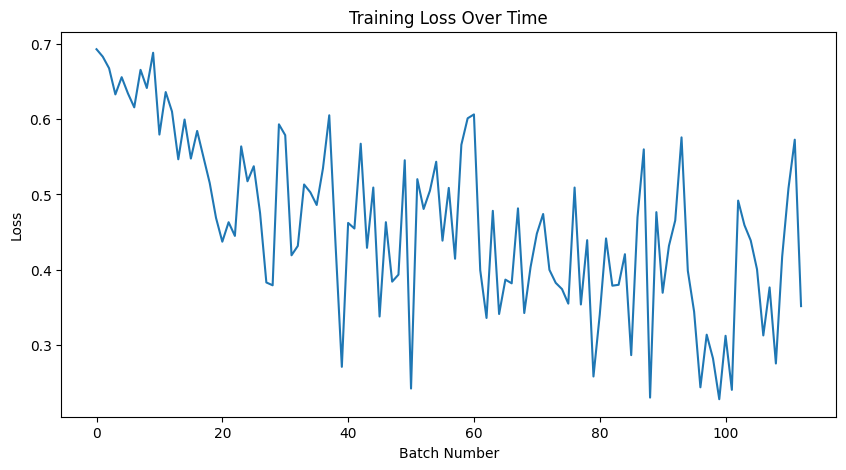

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

plt.show()

### Logits Difference Progression

Increasing logits difference shows the policy model is developing a stronger preference for chosen responses relative to the reference model.

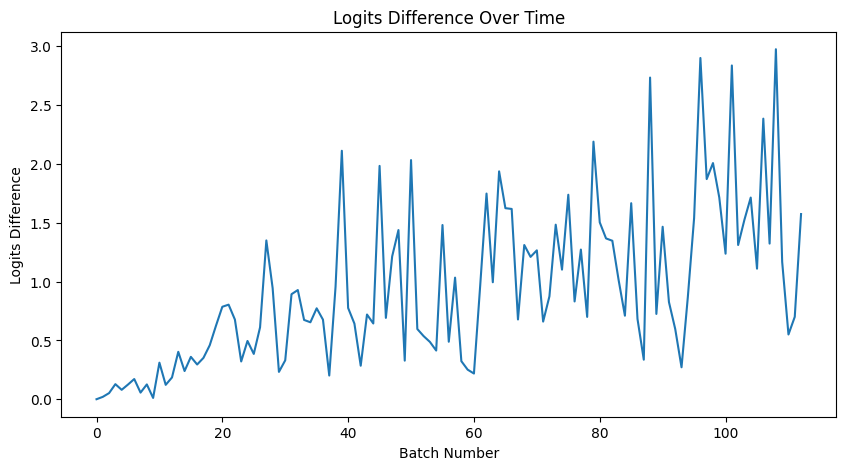

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(all_logits_diff, label='Logits Difference')
plt.xlabel('Batch Number')
plt.ylabel('Logits Difference')
plt.title('Logits Difference Over Time')

plt.show()

### Model Evaluation

Now we measure how well our alignment worked by comparing:
1. **Reference Model Accuracy**: Baseline preference accuracy (pre-alignment)
2. **Policy Model Accuracy**: Post-alignment preference accuracy

The accuracy metric: How often does the model assign higher log-probability to the chosen response versus the rejected one?

In [169]:
# TODO: Define the function
def compute_accuracy(logits_diff):
    """
    Computes accuracy: how often the model prefers the chosen response (logits_diff > 0)
    
    Args:
        logits_diff (Tensor): Vector of logits differences for a batch
    
    Returns:
        accuracy (float): Accuracy as a decimal (between 0 and 1)
    """
    correct = (logits_diff > 0).float().mean()
    return correct.item()

In [170]:
# TODO: Define the function
def evaluate_dpo_accuracy(model, loader, beta=0.1):
    """
    Evaluates how often the model prefers the chosen response over the rejected one.

    Args:
        model: The model to evaluate (either reference or policy).
        loader: DataLoader providing batches of prompt/chosen/rejected text.
        beta: DPO scaling factor (optional, usually has no effect here).

    Returns:
        Float: accuracy (between 0 and 1)
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            prompts  = batch["prompt"]
            chosen   = batch["chosen"]
            rejected = batch["rejected"]

            # Tokenize using your *SmolLM tokenizer* (NOT the reward tokenizer!)
            tok_chosen   = tokenizer(prompts, chosen, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
            tok_rejected = tokenizer(prompts, rejected, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

            # Compute average log-probs for each sample
            logp_ch = compute_logprob(model, **tok_chosen)
            logp_rj = compute_logprob(model, **tok_rejected)

            # DPO-style decision: does model prefer chosen over rejected?
            logits_diff = beta * (logp_ch - logp_rj)
            correct += (logits_diff > 0).sum().item()
            total   += logits_diff.size(0)

    return correct / total if total > 0 else 0.0

ref_acc = evaluate_dpo_accuracy(reference_model, test_loader)
policy_acc = evaluate_dpo_accuracy(policy_model, test_loader)

print(f"Reference Model Accuracy: {ref_acc * 100:.2f}%")
print(f"Policy Model Accuracy:    {policy_acc * 100:.2f}%")

Reference Model Accuracy: 72.00%
Policy Model Accuracy:    92.00%


### Qualitative Comparison: Reference vs Policy

Let's generate actual responses from both models to see the practical impact of DPO alignment. We'll sample random prompts from the test set and compare outputs.

In [ ]:
for idx in random.sample(range(len(test_data)), 3):
    ex = test_data[idx]
    prompt = ex["prompt"].strip()
    print(f"\nPrompt:\n{prompt}\n")

    toks = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    ).to(device)

    ref_inputs = {
        "input_ids": toks["input_ids"].clone(),
        "attention_mask": toks["attention_mask"].clone()
    }
    ref_response = __generate(reference_model, ref_inputs, 50, tokenizer).strip()
    if not ref_response:
        ref_response = "[no tokens generated]"

    pol_inputs = {
        "input_ids": toks["input_ids"].clone(),
        "attention_mask": toks["attention_mask"].clone()
    }
    policy_response = __generate(policy_model, pol_inputs, 50, tokenizer).strip()
    if not policy_response:
        policy_response = "[no tokens generated]"

    print("Reference:", ref_response)
    print("Policy:   ", policy_response)
    print("-" * 80)



Prompt:
Human: Are the oceans on planet Earth fully explored?

Assistant: Not entirely, but there has been a vast amount of exploratory work and data collection, including since the 70s.

Human: Surely exploration of the oceans began much earlier?

Assistant: You’re right that ancient oceanography dates back to the beginnings of human history.  That was followed by new interest and major changes in technological capability in the Renaissance.  In a historic progression, these developments have slowly increased our understanding of the oceans, although most is still not fully understood.

Human: How much of the ocean is still unexplored or unmapped?

Assistant:

Reference: The oceans cover about 71% of Earth's surface, and they contain more than 97% of its water.  They are home to a wide variety of life forms, from microscopic bacteria to giant blue whales.  The oceans are
Policy:    Estimates range from 10% to 90%.  Much of the unexplored ocean remains understudied due to factors such

### Observations on Generated Responses

**Reference Model**: Maintains general factual relevance but often lacks specificity or ends abruptly. Responses are safe but generic.

**Policy Model**: After DPO alignment, shows attempts at more detailed responses, though sometimes introduces fabricated details or oversimplified repetition. This indicates the model is learning to prefer more elaborate responses, but may need further tuning to maintain factual grounding.

**Key Insight**: The trade-off between preference alignment and factual accuracy is evident. Future iterations could benefit from combining DPO with factuality constraints or using higher-quality preference data.

## Analysis & Insights

Understanding the key factors that affect DPO performance and potential failure modes.

### Q1: Policy vs Reference Model Performance

**Observation**: The policy model typically achieves higher preference accuracy than the reference model after DPO training, demonstrating successful alignment.

**Limiting Factors**:
1. **Data Quality**: Noisy or weak preference examples can confuse the model. Ambiguous pairs where chosen/rejected are similar provide weak learning signal.
2. **Hyperparameter Tuning**: Suboptimal learning rate, β value, or training duration can limit performance. β controls the strength of alignment - too high keeps the model close to reference, too low can cause overfitting.

**Future Improvements**: Better data filtering, hyperparameter search, and longer training could further improve accuracy.

---

### Q2: The β Parameter

**Role**: β is the temperature parameter that controls how strongly the policy should stay close to the reference model.

**Effects**:
- **Too High**: Policy barely changes from reference → minimal alignment improvement
- **Too Low**: Policy may overfit to training preferences → produces extreme or nonsensical outputs
- **Optimal Range**: Typically 0.1-0.5, balancing alignment strength with stability

**Analogy**: Think of β as a "trust" parameter - how much should we trust the preference data versus the pre-trained model?

---

### Q3: Reference Model in Training Loop

**What Happens**: If you accidentally use reference model's log-probs for both policy and reference in the loss calculation, the preference signal disappears.

**Why**: The DPO loss depends on the *difference* between policy and reference preferences. If they're the same model, `(policy_delta - ref_delta) = 0`, making the loss meaningless.

**Result**: No learning occurs - the loss stays constant and the model doesn't improve.

---

### Q4: Length Bias in Preferences

**Problem**: If rejected responses are much longer than chosen ones, the model may incorrectly learn that "shorter is better" because:
- Longer sequences have more tokens to predict
- Average log-probability naturally decreases with length
- Model gets penalized for longer text even if quality is good

**Solutions**:
1. **Normalize per token**: Divide total log-prob by sequence length
2. **Filter data**: Remove examples with extreme length imbalances
3. **Length-aware loss**: Weight preferences by relative length

---

### Q5: Practical Implementation Challenge

**Problem Encountered**: Initially, both policy and reference models computed log-probs from the same model weights due to improper model separation.

**Symptoms**: 
- Loss stayed constant
- No improvement in preference accuracy
- Gradients were very small

**Solution**: Ensured proper model separation:
```python
# Policy model - trainable
policy_logprobs = compute_logprob(policy_model, ...)

# Reference model - frozen, separate forward pass
with torch.no_grad():
    ref_logprobs = compute_logprob(reference_model, ...)
```

**Lesson**: Always verify model separation in preference optimization - it's a common pitfall that silently breaks training.